In [49]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import vstack
from numpy import asarray

In [50]:
np.random.seed(42)

In [51]:

input_shape = (28, 28, 1)

# load into train and test splits:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data() 
#combine into a single dataset
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = expand_dims(mnist, axis=-1)

# Scale images to the [0, 1] range
mnist = mnist.astype("float32") / 255

mnist.shape

(70000, 28, 28, 1)

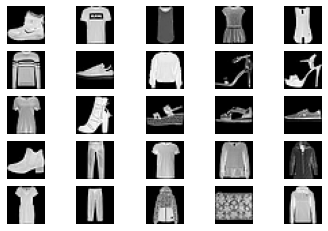

In [52]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray')
plt.show()

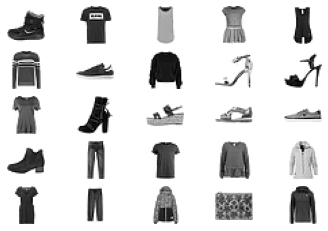

In [53]:
# plot reverse gray scale:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')
plt.show()

In [54]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (5,5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the discriminator model
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)         

In [55]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (1,1), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model
 
# size of the latent space
latent_dim = 100
# define the discriminator model
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 28, 28, 128)      

In [56]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 28, 28, 1)         1180801   
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 143169    
Total params: 1,323,970
Trainable params: 1,180,801
Non-trainable params: 143,169
_________________________________________________________________


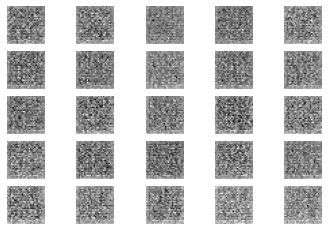

In [57]:

# without training, our generator model produces really bad images (they are not very good):

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_generator_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# generate samples
n_samples = 25
X, _ = generate_fake_generator_samples(generator, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

In [58]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    #save_plot(x_fake, epoch)
    # save the generator model tile file
    #filename = 'generator_model_%03d.h5' % (epoch + 1)
    #g_model.save(filename)  # serializing the model: https://www.tensorflow.org/tutorials/keras/save_and_load
    
# train the generator and discriminator together
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d_loss=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        #if (i+1) % 10 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)
            
    return g_model

In [ ]:
# size of the latent space
latent_dim = 100
# train model
trained_generator = train(generator, discriminator, gan_model, mnist, latent_dim, 20)

>1, 1/273, d_loss=0.696, g_loss=0.704
>1, 2/273, d_loss=0.690, g_loss=0.720
>1, 3/273, d_loss=0.682, g_loss=0.735
>1, 4/273, d_loss=0.675, g_loss=0.749
>1, 5/273, d_loss=0.666, g_loss=0.763
>1, 6/273, d_loss=0.663, g_loss=0.770
>1, 7/273, d_loss=0.656, g_loss=0.792
>1, 8/273, d_loss=0.650, g_loss=0.794
>1, 9/273, d_loss=0.636, g_loss=0.808
>1, 10/273, d_loss=0.626, g_loss=0.795
>1, 11/273, d_loss=0.616, g_loss=0.790
>1, 12/273, d_loss=0.606, g_loss=0.773
>1, 13/273, d_loss=0.581, g_loss=0.762
>1, 14/273, d_loss=0.562, g_loss=0.738
>1, 15/273, d_loss=0.557, g_loss=0.745
>1, 16/273, d_loss=0.532, g_loss=0.777
>1, 17/273, d_loss=0.520, g_loss=0.836
>1, 18/273, d_loss=0.502, g_loss=0.879
>1, 19/273, d_loss=0.467, g_loss=0.877
>1, 20/273, d_loss=0.474, g_loss=0.846
>1, 21/273, d_loss=0.465, g_loss=0.784
>1, 22/273, d_loss=0.439, g_loss=0.744
>1, 23/273, d_loss=0.434, g_loss=0.720
>1, 24/273, d_loss=0.450, g_loss=0.716
>1, 25/273, d_loss=0.450, g_loss=0.746
>1, 26/273, d_loss=0.453, g_loss=0

>1, 209/273, d_loss=0.706, g_loss=0.722
>1, 210/273, d_loss=0.710, g_loss=0.755
>1, 211/273, d_loss=0.690, g_loss=0.780
>1, 212/273, d_loss=0.692, g_loss=0.800
>1, 213/273, d_loss=0.684, g_loss=0.820
>1, 214/273, d_loss=0.673, g_loss=0.849
>1, 215/273, d_loss=0.674, g_loss=0.843
>1, 216/273, d_loss=0.677, g_loss=0.870
>1, 217/273, d_loss=0.679, g_loss=0.866
>1, 218/273, d_loss=0.676, g_loss=0.857
>1, 219/273, d_loss=0.666, g_loss=0.835
>1, 220/273, d_loss=0.675, g_loss=0.840
>1, 221/273, d_loss=0.671, g_loss=0.830
>1, 222/273, d_loss=0.671, g_loss=0.819
>1, 223/273, d_loss=0.665, g_loss=0.807
>1, 224/273, d_loss=0.670, g_loss=0.789
>1, 225/273, d_loss=0.660, g_loss=0.756
>1, 226/273, d_loss=0.669, g_loss=0.761
>1, 227/273, d_loss=0.675, g_loss=0.719
>1, 228/273, d_loss=0.677, g_loss=0.705
>1, 229/273, d_loss=0.676, g_loss=0.703
>1, 230/273, d_loss=0.679, g_loss=0.696
>1, 231/273, d_loss=0.683, g_loss=0.711
>1, 232/273, d_loss=0.664, g_loss=0.714
>1, 233/273, d_loss=0.672, g_loss=0.735


>2, 144/273, d_loss=0.676, g_loss=0.718
>2, 145/273, d_loss=0.681, g_loss=0.719
>2, 146/273, d_loss=0.678, g_loss=0.718
>2, 147/273, d_loss=0.673, g_loss=0.731
>2, 148/273, d_loss=0.680, g_loss=0.742
>2, 149/273, d_loss=0.679, g_loss=0.749
>2, 150/273, d_loss=0.671, g_loss=0.749
>2, 151/273, d_loss=0.681, g_loss=0.746
>2, 152/273, d_loss=0.681, g_loss=0.742
>2, 153/273, d_loss=0.678, g_loss=0.728
>2, 154/273, d_loss=0.687, g_loss=0.722
>2, 155/273, d_loss=0.689, g_loss=0.723
>2, 156/273, d_loss=0.692, g_loss=0.738
>2, 157/273, d_loss=0.689, g_loss=0.743
>2, 158/273, d_loss=0.690, g_loss=0.753
>2, 159/273, d_loss=0.687, g_loss=0.760
>2, 160/273, d_loss=0.696, g_loss=0.735
>2, 161/273, d_loss=0.690, g_loss=0.742
>2, 162/273, d_loss=0.697, g_loss=0.744
>2, 163/273, d_loss=0.687, g_loss=0.737
>2, 164/273, d_loss=0.688, g_loss=0.721
>2, 165/273, d_loss=0.688, g_loss=0.709
>2, 166/273, d_loss=0.684, g_loss=0.712
>2, 167/273, d_loss=0.688, g_loss=0.700
>2, 168/273, d_loss=0.680, g_loss=0.711


>3, 78/273, d_loss=0.674, g_loss=0.697
>3, 79/273, d_loss=0.672, g_loss=0.691
>3, 80/273, d_loss=0.668, g_loss=0.682
>3, 81/273, d_loss=0.669, g_loss=0.687
>3, 82/273, d_loss=0.663, g_loss=0.705
>3, 83/273, d_loss=0.658, g_loss=0.698
>3, 84/273, d_loss=0.666, g_loss=0.714
>3, 85/273, d_loss=0.670, g_loss=0.730
>3, 86/273, d_loss=0.670, g_loss=0.753
>3, 87/273, d_loss=0.667, g_loss=0.757
>3, 88/273, d_loss=0.669, g_loss=0.765
>3, 89/273, d_loss=0.669, g_loss=0.800
>3, 90/273, d_loss=0.661, g_loss=0.795
>3, 91/273, d_loss=0.665, g_loss=0.789
>3, 92/273, d_loss=0.679, g_loss=0.756
>3, 93/273, d_loss=0.685, g_loss=0.712
>3, 94/273, d_loss=0.679, g_loss=0.711
>3, 95/273, d_loss=0.687, g_loss=0.696
>3, 96/273, d_loss=0.692, g_loss=0.681
>3, 97/273, d_loss=0.678, g_loss=0.667
>3, 98/273, d_loss=0.666, g_loss=0.666
>3, 99/273, d_loss=0.686, g_loss=0.664
>3, 100/273, d_loss=0.666, g_loss=0.666
>3, 101/273, d_loss=0.655, g_loss=0.683
>3, 102/273, d_loss=0.676, g_loss=0.706
>3, 103/273, d_loss=0.

>4, 11/273, d_loss=0.652, g_loss=0.738
>4, 12/273, d_loss=0.655, g_loss=0.741
>4, 13/273, d_loss=0.637, g_loss=0.725
>4, 14/273, d_loss=0.645, g_loss=0.711
>4, 15/273, d_loss=0.636, g_loss=0.722
>4, 16/273, d_loss=0.634, g_loss=0.724
>4, 17/273, d_loss=0.634, g_loss=0.736
>4, 18/273, d_loss=0.637, g_loss=0.766
>4, 19/273, d_loss=0.654, g_loss=0.798
>4, 20/273, d_loss=0.660, g_loss=0.835
>4, 21/273, d_loss=0.673, g_loss=0.857
>4, 22/273, d_loss=0.682, g_loss=0.775
>4, 23/273, d_loss=0.697, g_loss=0.720
>4, 24/273, d_loss=0.683, g_loss=0.695
>4, 25/273, d_loss=0.679, g_loss=0.693
>4, 26/273, d_loss=0.700, g_loss=0.704
>4, 27/273, d_loss=0.703, g_loss=0.706
>4, 28/273, d_loss=0.671, g_loss=0.699
>4, 29/273, d_loss=0.685, g_loss=0.706
>4, 30/273, d_loss=0.671, g_loss=0.730
>4, 31/273, d_loss=0.668, g_loss=0.730
>4, 32/273, d_loss=0.664, g_loss=0.747
>4, 33/273, d_loss=0.655, g_loss=0.767
>4, 34/273, d_loss=0.672, g_loss=0.781
>4, 35/273, d_loss=0.651, g_loss=0.800
>4, 36/273, d_loss=0.659,

>4, 219/273, d_loss=0.666, g_loss=0.783
>4, 220/273, d_loss=0.658, g_loss=0.777
>4, 221/273, d_loss=0.667, g_loss=0.804
>4, 222/273, d_loss=0.670, g_loss=0.751
>4, 223/273, d_loss=0.674, g_loss=0.754
>4, 224/273, d_loss=0.648, g_loss=0.798
>4, 225/273, d_loss=0.658, g_loss=0.822
>4, 226/273, d_loss=0.662, g_loss=0.817
>4, 227/273, d_loss=0.645, g_loss=0.799
>4, 228/273, d_loss=0.647, g_loss=0.778
>4, 229/273, d_loss=0.654, g_loss=0.747
>4, 230/273, d_loss=0.673, g_loss=0.757
>4, 231/273, d_loss=0.676, g_loss=0.714
>4, 232/273, d_loss=0.655, g_loss=0.687
>4, 233/273, d_loss=0.670, g_loss=0.721
>4, 234/273, d_loss=0.664, g_loss=0.740
>4, 235/273, d_loss=0.665, g_loss=0.770
>4, 236/273, d_loss=0.659, g_loss=0.804
>4, 237/273, d_loss=0.640, g_loss=0.834
>4, 238/273, d_loss=0.653, g_loss=0.840
>4, 239/273, d_loss=0.642, g_loss=0.838
>4, 240/273, d_loss=0.659, g_loss=0.876
>4, 241/273, d_loss=0.665, g_loss=0.880
>4, 242/273, d_loss=0.672, g_loss=0.862
>4, 243/273, d_loss=0.684, g_loss=0.863


>5, 154/273, d_loss=0.681, g_loss=0.948
>5, 155/273, d_loss=0.675, g_loss=0.917
>5, 156/273, d_loss=0.652, g_loss=1.008
>5, 157/273, d_loss=0.605, g_loss=1.068
>5, 158/273, d_loss=0.615, g_loss=0.931
>5, 159/273, d_loss=0.626, g_loss=0.842
>5, 160/273, d_loss=0.638, g_loss=0.787
>5, 161/273, d_loss=0.629, g_loss=0.752
>5, 162/273, d_loss=0.639, g_loss=0.747
>5, 163/273, d_loss=0.627, g_loss=0.762
>5, 164/273, d_loss=0.578, g_loss=0.779
>5, 165/273, d_loss=0.563, g_loss=0.788
>5, 166/273, d_loss=0.594, g_loss=0.823
>5, 167/273, d_loss=0.621, g_loss=0.961
>5, 168/273, d_loss=0.631, g_loss=1.087
>5, 169/273, d_loss=0.646, g_loss=1.034
>5, 170/273, d_loss=0.640, g_loss=0.886
>5, 171/273, d_loss=0.631, g_loss=0.878
>5, 172/273, d_loss=0.623, g_loss=0.925
>5, 173/273, d_loss=0.620, g_loss=0.916
>5, 174/273, d_loss=0.640, g_loss=0.915
>5, 175/273, d_loss=0.624, g_loss=0.761
>5, 176/273, d_loss=0.688, g_loss=0.704
>5, 177/273, d_loss=0.672, g_loss=0.732
>5, 178/273, d_loss=0.627, g_loss=0.825


>6, 89/273, d_loss=0.689, g_loss=0.770
>6, 90/273, d_loss=0.648, g_loss=0.780
>6, 91/273, d_loss=0.637, g_loss=0.773
>6, 92/273, d_loss=0.662, g_loss=0.772
>6, 93/273, d_loss=0.640, g_loss=0.777
>6, 94/273, d_loss=0.680, g_loss=0.779
>6, 95/273, d_loss=0.634, g_loss=0.829
>6, 96/273, d_loss=0.665, g_loss=0.828
>6, 97/273, d_loss=0.674, g_loss=0.823
>6, 98/273, d_loss=0.657, g_loss=0.779
>6, 99/273, d_loss=0.655, g_loss=0.774
>6, 100/273, d_loss=0.647, g_loss=0.816
>6, 101/273, d_loss=0.651, g_loss=0.856
>6, 102/273, d_loss=0.659, g_loss=0.827
>6, 103/273, d_loss=0.656, g_loss=0.801
>6, 104/273, d_loss=0.672, g_loss=0.711
>6, 105/273, d_loss=0.668, g_loss=0.722
>6, 106/273, d_loss=0.686, g_loss=0.764
>6, 107/273, d_loss=0.700, g_loss=0.738
>6, 108/273, d_loss=0.699, g_loss=0.820
>6, 109/273, d_loss=0.688, g_loss=0.807
>6, 110/273, d_loss=0.684, g_loss=0.717
>6, 111/273, d_loss=0.700, g_loss=0.753
>6, 112/273, d_loss=0.688, g_loss=0.853
>6, 113/273, d_loss=0.680, g_loss=0.882
>6, 114/273

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and display a plot of generated images (reversed grayscale)
def display_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load model
#model = load_model('generator_model_100.h5') #load the last seralized model (latest version of the GAN model)
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = trained_generator.predict(latent_points)
# plot the result
display_plot(X, 5)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and display a plot of generated images (reversed grayscale)
def display_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load model
#model = load_model('generator_model_100.h5') #load the last seralized model (latest version of the GAN model)
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = trained_generator.predict(latent_points)
# plot the result
display_plot(X, 5)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and display a plot of generated images (reversed grayscale)
def display_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load model
#model = load_model('generator_model_100.h5') #load the last seralized model (latest version of the GAN model)
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = trained_generator.predict(latent_points)
# plot the result
display_plot(X, 5)